## Importing Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from PIL import Image
from tqdm.notebook import tqdm
import random
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras. models import Sequential, Model
from keras.layers import Dense, Conv2D , Dropout , Flatten , MaxPooling2D , Input


## Loading the Dataset

In [2]:
dir = '/kaggle/input/utkface-new/UTKFace/'

In [3]:
dir

'/kaggle/input/utkface-new/UTKFace/'

In [4]:
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(dir)):
    image_path = os.path.join(dir,filename)
    temp = filename.split('_')
    image_paths.append(image_path)
    age_labels.append(int(temp[0]))
    gender_labels.append(int(temp[1]))

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

In [6]:
df.head(20)

,image,age,gender
0,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...,26,0
1,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...,22,1
2,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...,21,1
3,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...,28,0
4,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...,17,1
5,/kaggle/input/utkface-new/UTKFace/44_0_3_20170...,44,0
6,/kaggle/input/utkface-new/UTKFace/35_0_2_20170...,35,0
7,/kaggle/input/utkface-new/UTKFace/76_0_0_20170...,76,0
8,/kaggle/input/utkface-new/UTKFace/36_1_0_20170...,36,1
9,/kaggle/input/utkface-new/UTKFace/34_0_3_20170...,34,0


In [7]:
df.shape

(23708, 3)

## EDA

In [8]:
gender_dict = {0:'Male', 1:'Female'}

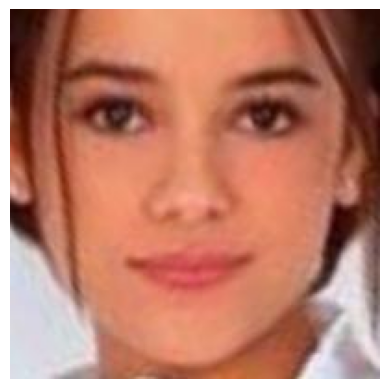

In [9]:
img = Image.open(df['image'][10])
plt.axis('off')
plt.imshow(img)

<Axes: xlabel='age', ylabel='Density'>

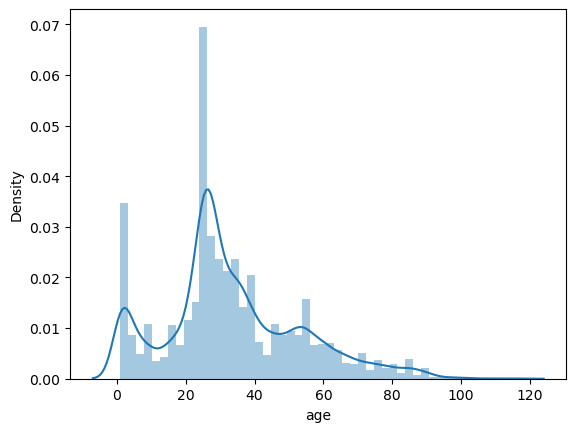

In [10]:
sns.distplot(df['age'])

<Axes: xlabel='gender', ylabel='count'>

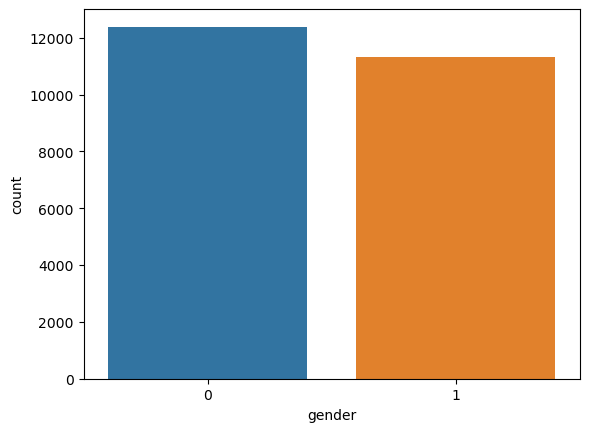

In [11]:
sns.countplot(data=df , x='gender')

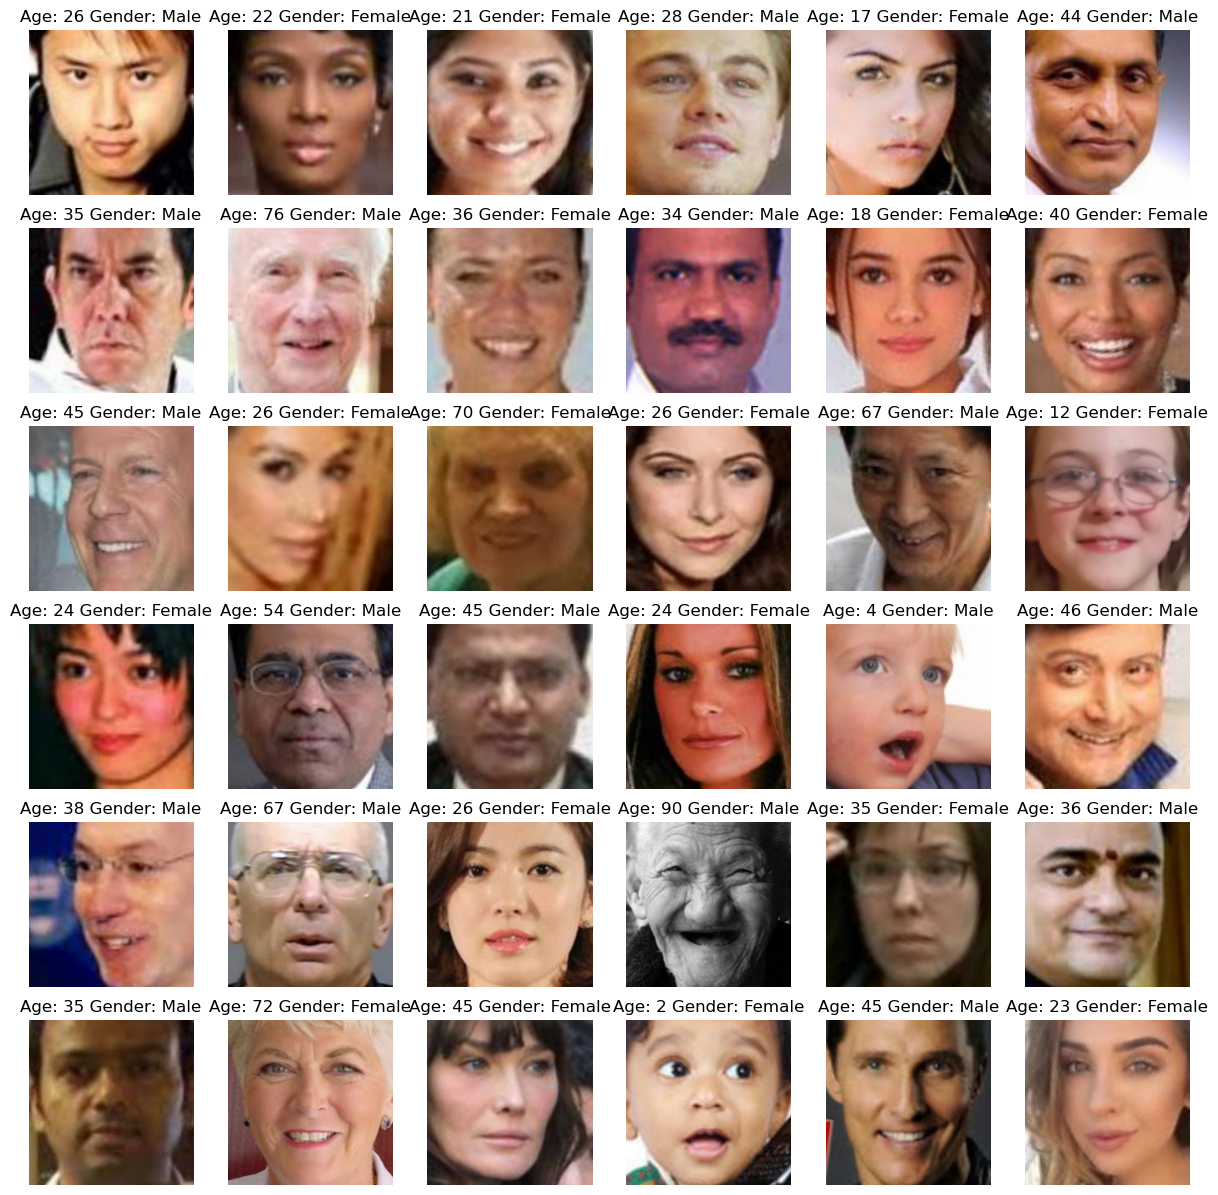

In [12]:
plt.figure(figsize=(15, 15))
files = df.iloc[0:36]

for index, file, age, gender in files.itertuples():
    plt.subplot(6,6, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

## Featue Extraction

In [13]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [14]:
X = extract_features(df['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [15]:
X.shape

(23708, 128, 128, 1)

In [16]:
# normalize the images
X = X/255.0

In [17]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [18]:
input_shape = (128, 128, 1)

## Model Creation

In [19]:
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs)
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

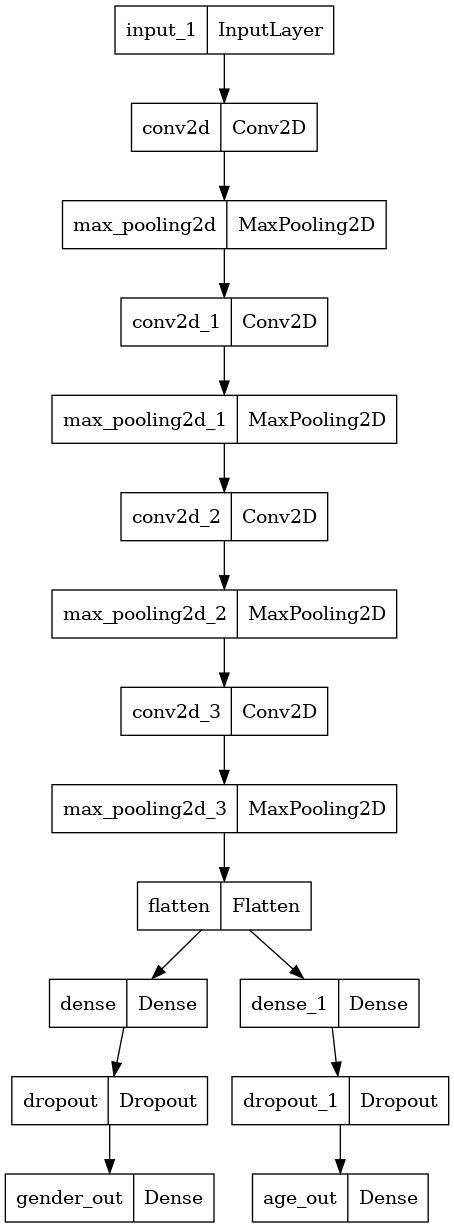

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(model)

## Training

In [21]:
predictor = model.fit(x=X, y=[y_gender, y_age], batch_size=32, epochs=38, validation_split=0.2)

Epoch 1/38
593/593 [==============================] - 26s 23ms/step - loss: 16.2233 - gender_out_loss: 0.6907 - age_out_loss: 15.5327 - gender_out_accuracy: 0.5491 - age_out_accuracy: 0.0474 - val_loss: 14.6874 - val_gender_out_loss: 0.6041 - val_age_out_loss: 14.0833 - val_gender_out_accuracy: 0.6744 - val_age_out_accuracy: 0.0462
Epoch 2/38
593/593 [==============================] - 12s 21ms/step - loss: 12.3595 - gender_out_loss: 0.5118 - age_out_loss: 11.8477 - gender_out_accuracy: 0.7473 - age_out_accuracy: 0.0371 - val_loss: 10.8036 - val_gender_out_loss: 0.4580 - val_age_out_loss: 10.3456 - val_gender_out_accuracy: 0.7760 - val_age_out_accuracy: 0.0264
Epoch 3/38
593/593 [==============================] - 12s 20ms/step - loss: 10.2468 - gender_out_loss: 0.4242 - age_out_loss: 9.8226 - gender_out_accuracy: 0.8031 - age_out_accuracy: 0.0187 - val_loss: 9.1787 - val_gender_out_loss: 0.3903 - val_age_out_loss: 8.7884 - val_gender_out_accuracy: 0.8226 - val_age_out_accuracy: 0.0167
E

## Ploting the Results

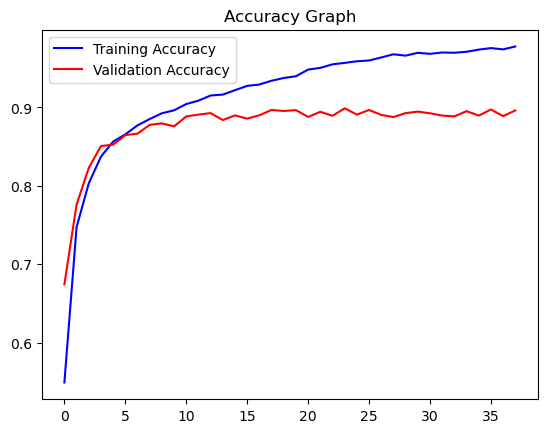

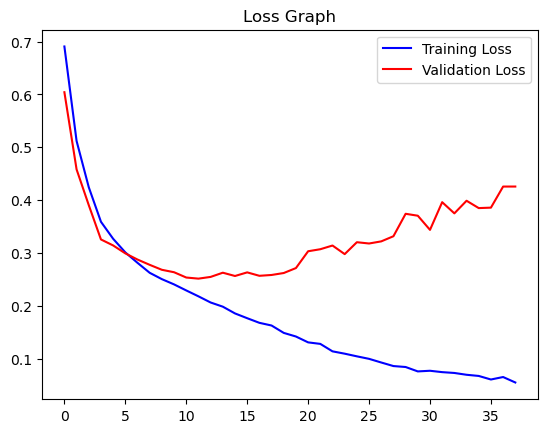

In [24]:
# plot results for gender
acc = predictor.history['gender_out_accuracy']
val_acc = predictor.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = predictor.history['gender_out_loss']
val_loss = predictor.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

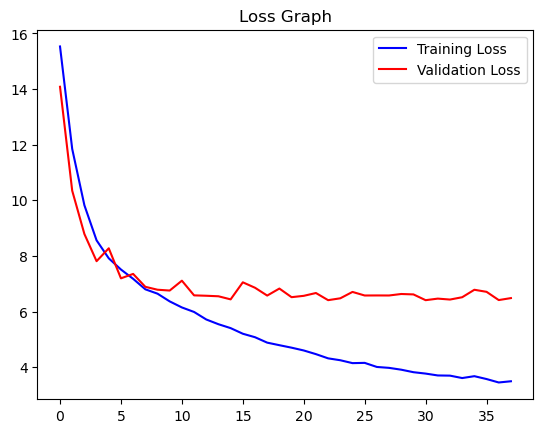

In [25]:
# plot results for age
loss = predictor.history['age_out_loss']
val_loss = predictor.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

## Prediction with Test Data

Original Gender: Male 
Original Age: 21
1/1 [==============================] - 0s 21ms/step
Predicted Gender: Male 
Predicted Age: 22


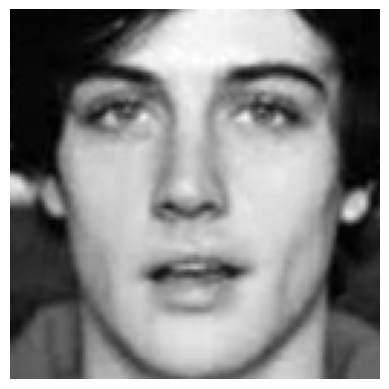

In [32]:
image_index = 10897
print("Original Gender:", gender_dict[y_gender[image_index]],"\nOriginal Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female 
Original Age: 22
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female 
Predicted Age: 23


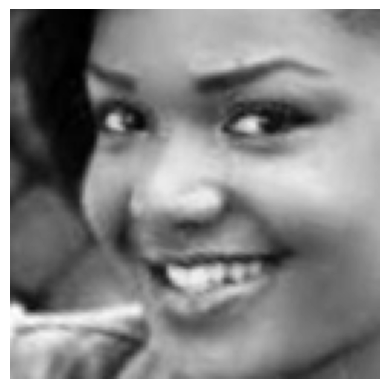

In [33]:
image_index = 12310
print("Original Gender:", gender_dict[y_gender[image_index]],"\nOriginal Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male 
Original Age: 58
1/1 [==============================] - 0s 19ms/step
Predicted Gender: Male 
Predicted Age: 54


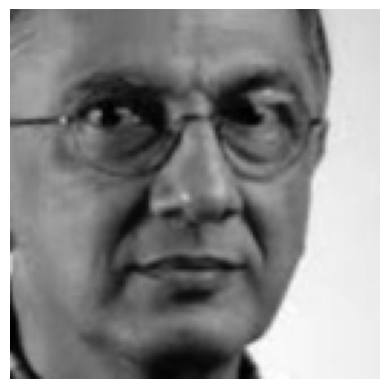

In [34]:
image_index = 1990
print("Original Gender:", gender_dict[y_gender[image_index]],"\nOriginal Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male 
Original Age: 70
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male 
Predicted Age: 73


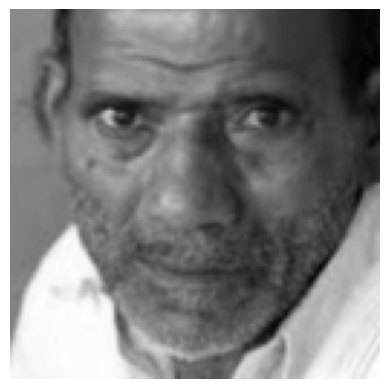

In [35]:
image_index = 99
print("Original Gender:", gender_dict[y_gender[image_index]],"\nOriginal Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female 
Original Age: 72
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Female 
Predicted Age: 91


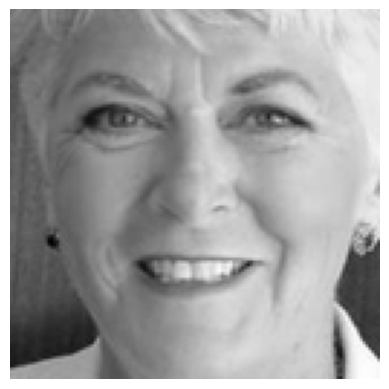

In [36]:
image_index = 31
print("Original Gender:", gender_dict[y_gender[image_index]],"\nOriginal Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male 
Original Age: 61
1/1 [==============================] - 0s 20ms/step
Predicted Gender: Male 
Predicted Age: 59


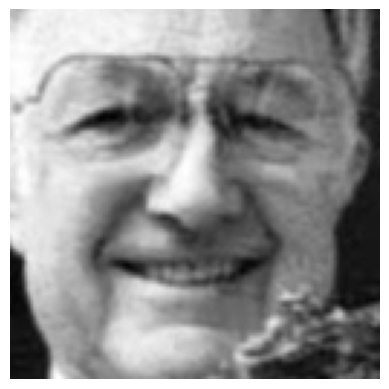

In [37]:
image_index = 14788
print("Original Gender:", gender_dict[y_gender[image_index]],"\nOriginal Age:", y_age[image_index])
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "\nPredicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

In [38]:
print(val_acc[-1])

0.8960354328155518


In [39]:
#Accuracy is approximately 90%